In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


144 ['../data/rubin_tiles_ecdfs/tile_x00000_y00000.npz', '../data/rubin_tiles_ecdfs/tile_x00000_y00256.npz', '../data/rubin_tiles_ecdfs/tile_x00000_y00512.npz']
['img', 'var', 'mask', 'wcs_hdr', 'x0', 'y0', 'tile_id', 'ra_center', 'dec_center', 'tile_size', 'stride', 'bands']


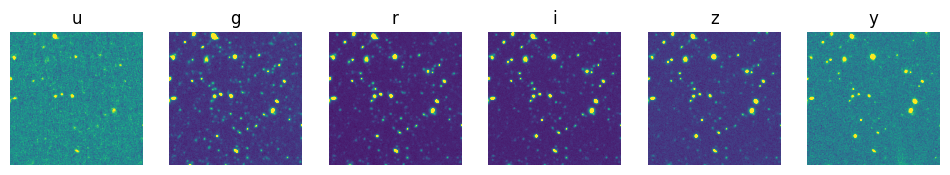

In [2]:
DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs")

files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
print(len(files), files[:3])

f = np.load(files[0])
print(f.files)
img  = f["img"]  
bands = ["u", "g", "r", "i","z","y"]

fig, axs = plt.subplots(1, img.shape[0], figsize=(12,4))
for i, ax in enumerate(axs):
    lo, hi = np.percentile(img[i], (1,99))
    ax.imshow(img[i], origin="lower", vmin=lo, vmax=hi)
    ax.set_title(bands[i])
    ax.axis("off")
plt.show()


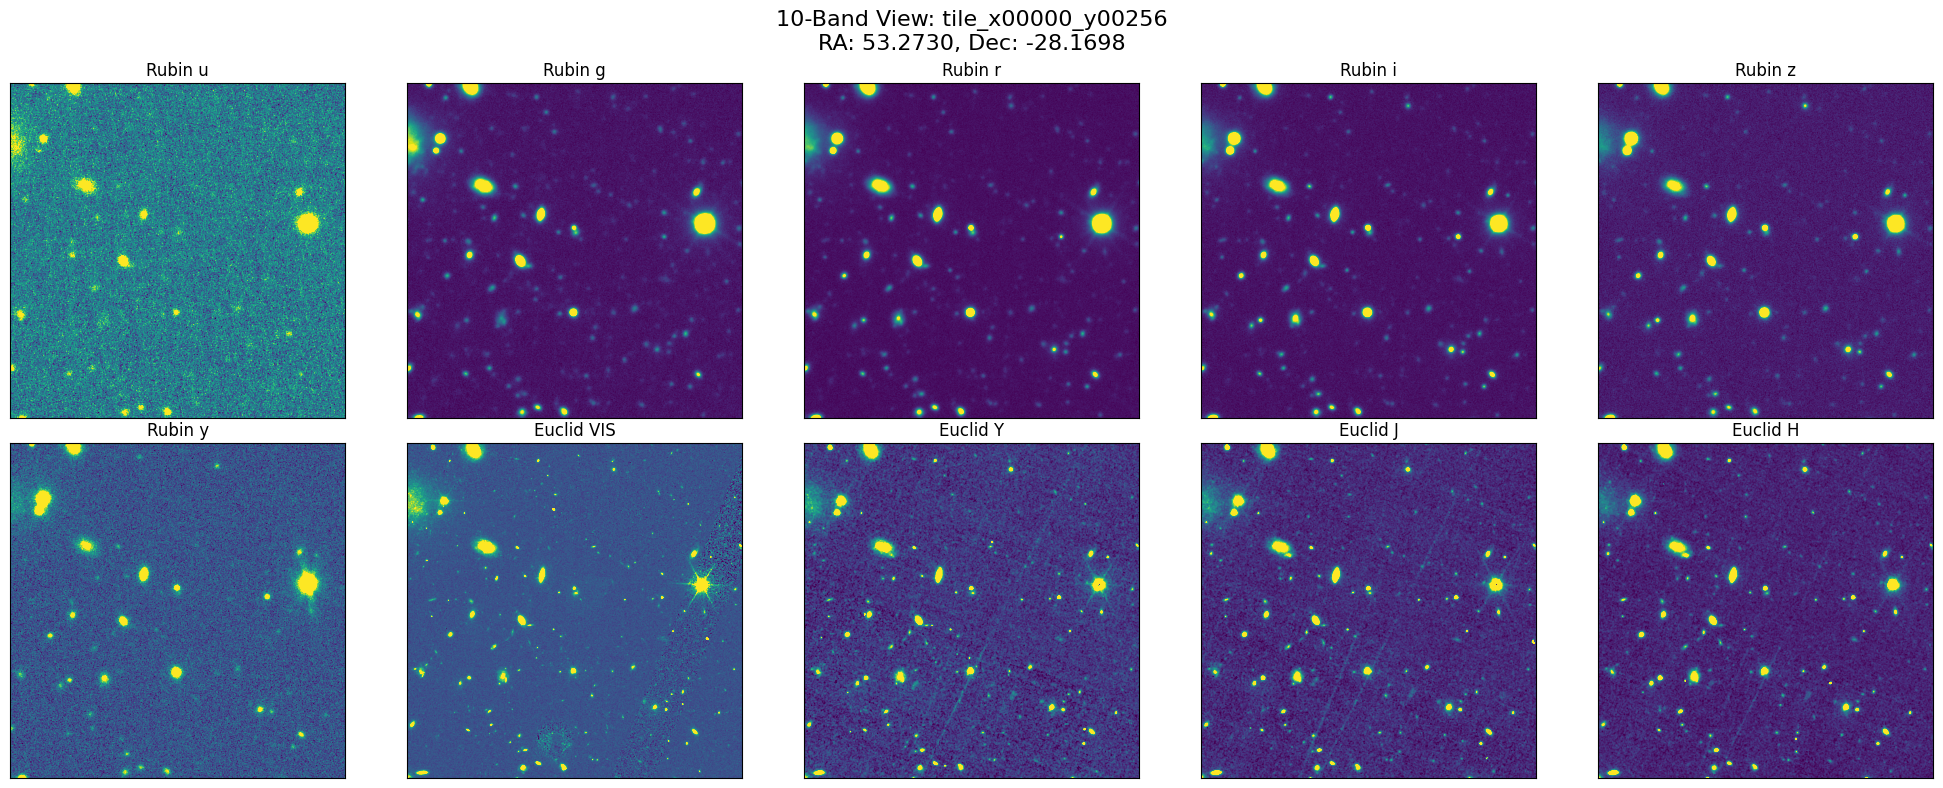

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
OUT_EUCLID_DIR = "../data/euclid_tiles_ecdfs"

# ---- Path Configuration ----
tile_id_str = "tile_x00000_y00256"
rubin_path  = os.path.join(OUT_RUBIN_DIR,  f"{tile_id_str}.npz")
euclid_path = os.path.join(OUT_EUCLID_DIR, f"{tile_id_str}_euclid.npz")

# 1. Load Data
r_data = np.load(rubin_path)
e_data = np.load(euclid_path)

# Bands Mapping
# Rubin: u, g, r, i, z, y (indices 0-5)
# Euclid: VIS, Y, J, H
rubin_bands = ["u", "g", "r", "i", "z", "y"]
euclid_bands = ["VIS", "Y", "J", "H"]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 2. Plot Rubin Bands (Top Row + 1st of Bottom)
for i, band in enumerate(rubin_bands):
    ax = axes[i]
    img = r_data['img'][i]
    robust_imshow(ax, img, title=f"Rubin {band}")

# 3. Plot Euclid Bands (Remaining 4 slots)
for i, band in enumerate(euclid_bands):
    ax = axes[i + 6] # Start at index 6
    img_key = f"img_{band}"
    
    if img_key in e_data:
        img = e_data[img_key]
        # We can also parse the WCS if needed:
        # wcs = WCS(e_data[f"wcs_{band}"]) 
        robust_imshow(ax, img, title=f"Euclid {band}")
    else:
        ax.set_title(f"Euclid {band} (Missing)")
        ax.axis('off')

plt.suptitle(f"10-Band View: {tile_id_str}\nRA: {r_data['ra_center']:.4f}, Dec: {r_data['dec_center']:.4f}", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

RUBIN_BANDS  = ["u", "g", "r", "i", "z", "y"]
EUCLID_BANDS = ["VIS", "Y", "J", "H"]

def _to_float32(x):
    x = np.asarray(x)
    return x.astype(np.float32, copy=False) if x.dtype != np.float32 else x

def _extract_wcs_like(npz_obj, band=None):
    if band is None:
        for k in ("wcs", "WCS", "header", "fits_header"):
            if k in npz_obj:
                return npz_obj[k]
        return None
    for k in (f"wcs_{band}", f"WCS_{band}", f"header_{band}", f"fits_header_{band}"):
        if k in npz_obj:
            return npz_obj[k]
    return None

def jaisp_collate_variable(batch):
    """
    Variable-size collate: keep images/rms as lists.
    """
    out = {
        "x_rubin":  [b["x_rubin"] for b in batch],     # list (6,Hr,Wr)
        "x_euclid": [b["x_euclid"] for b in batch],    # list (4,He,We)
        "mask_euclid": torch.stack([b["mask_euclid"] for b in batch], dim=0),  # (B,4)
        "meta":     [b["meta"] for b in batch],
    }

    # RMS is optional; keep as lists too (or None)
    out["rms_rubin"]  = [b.get("rms_rubin", None) for b in batch]
    out["rms_euclid"] = [b.get("rms_euclid", None) for b in batch]
    return out

class RubinEuclidTiles(Dataset):
    """
    EXACT-SIZE paired dataset (no crop/pad/resample, no augmentation).

    Rubin file:  <tile_id>.npz
      - img: (6,Hr,Wr)
      - OPTIONAL rms: (6,Hr,Wr)
      - ra_center, dec_center
      - optional: wcs/header

    Euclid file: <tile_id>_euclid.npz
      - img_VIS/img_Y/img_J/img_H
      - OPTIONAL rms_VIS/rms_Y/rms_J/rms_H
      - optional: wcs_VIS, etc.
    """
    def __init__(
        self,
        rubin_dir,
        euclid_dir,
        tile_ids=None,
        euclid_missing="zeros",      # for missing SCI: "zeros" | "nan"
        euclid_missing_rms="ones",   # for missing RMS:  "zeros" | "ones" | "nan"
        return_wcs=False,
        mmap=True,
    ):
        self.rubin_dir = rubin_dir
        self.euclid_dir = euclid_dir
        self.euclid_missing = euclid_missing
        self.euclid_missing_rms = euclid_missing_rms
        self.return_wcs = return_wcs
        self.mmap = mmap

        if tile_ids is None:
            rubin_files = sorted(glob.glob(os.path.join(rubin_dir, "tile_x*_y*.npz")))
            tile_ids = [os.path.splitext(os.path.basename(p))[0] for p in rubin_files]
        self.tile_ids = list(tile_ids)

        self.pairs = []
        for tid in self.tile_ids:
            rp = os.path.join(self.rubin_dir, f"{tid}.npz")
            ep = os.path.join(self.euclid_dir, f"{tid}_euclid.npz")
            if os.path.exists(rp):
                self.pairs.append((tid, rp, ep))
        if len(self.pairs) == 0:
            raise FileNotFoundError("No Rubin tiles found (tile_x*_y*.npz).")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        tile_id, rubin_path, euclid_path = self.pairs[idx]

        # ---- Rubin ----
        r = np.load(rubin_path, mmap_mode="r" if self.mmap else None, allow_pickle=True)
        rubin_img = _to_float32(r["img"])  # (6,Hr,Wr)
        ra = float(r["ra_center"]) if "ra_center" in r else np.nan
        dec = float(r["dec_center"]) if "dec_center" in r else np.nan

        rubin_rms = None
        if "rms" in r:
            rubin_rms = _to_float32(r["rms"])  # (6,Hr,Wr)

        # ---- Euclid ----
        mask_e = np.zeros((len(EUCLID_BANDS),), dtype=np.float32)
        e_stack, e_rms_stack = [], []
        wcs_e = {}

        if os.path.exists(euclid_path):
            e = np.load(euclid_path, mmap_mode="r" if self.mmap else None, allow_pickle=True)

            # find reference shape for placeholders
            ref_shape = None
            for b in EUCLID_BANDS:
                if f"img_{b}" in e:
                    ref_shape = e[f"img_{b}"].shape
                    break
            if ref_shape is None:
                ref_shape = rubin_img.shape[-2:]  # fallback only

            def fill_sci(shape):
                if self.euclid_missing == "nan":
                    return np.full(shape, np.nan, np.float32)
                return np.zeros(shape, np.float32)

            def fill_rms(shape):
                if self.euclid_missing_rms == "nan":
                    return np.full(shape, np.nan, np.float32)
                if self.euclid_missing_rms == "zeros":
                    return np.zeros(shape, np.float32)
                # default "ones": neutral weight (variance ~1)
                return np.ones(shape, np.float32)

            for j, b in enumerate(EUCLID_BANDS):
                k_img = f"img_{b}"
                if k_img in e:
                    img = _to_float32(e[k_img])
                    mask_e[j] = 1.0
                else:
                    img = fill_sci(ref_shape)
                e_stack.append(img)

                k_rms = f"rms_{b}"
                if k_rms in e:
                    rms = _to_float32(e[k_rms])
                else:
                    rms = fill_rms(ref_shape)
                e_rms_stack.append(rms)

                if self.return_wcs:
                    w = _extract_wcs_like(e, band=b)
                    if w is not None:
                        wcs_e[b] = w

        else:
            # no Euclid file at all: placeholders in Rubin shape
            ref_shape = rubin_img.shape[-2:]

            def fill_sci(shape):
                if self.euclid_missing == "nan":
                    return np.full(shape, np.nan, np.float32)
                return np.zeros(shape, np.float32)

            def fill_rms(shape):
                if self.euclid_missing_rms == "nan":
                    return np.full(shape, np.nan, np.float32)
                if self.euclid_missing_rms == "zeros":
                    return np.zeros(shape, np.float32)
                return np.ones(shape, np.float32)

            for _ in EUCLID_BANDS:
                e_stack.append(fill_sci(ref_shape))
                e_rms_stack.append(fill_rms(ref_shape))

        euclid_img = np.stack(e_stack, axis=0)         # (4,He,We)
        euclid_rms = np.stack(e_rms_stack, axis=0)     # (4,He,We)

        sample = {
            "x_rubin": torch.from_numpy(rubin_img),
            "x_euclid": torch.from_numpy(euclid_img),
            "mask_euclid": torch.from_numpy(mask_e),
            "meta": {
                "tile_id": tile_id,
                "ra_center": ra,
                "dec_center": dec,
                "rubin_path": rubin_path,
                "euclid_path": euclid_path,
                "rubin_bands": RUBIN_BANDS,
                "euclid_bands": EUCLID_BANDS,
                "rubin_hw": tuple(map(int, rubin_img.shape[-2:])),
                "euclid_hw": tuple(map(int, euclid_img.shape[-2:])),
            }
        }

        if rubin_rms is not None:
            sample["rms_rubin"] = torch.from_numpy(rubin_rms)
        # always return euclid rms (real or placeholder), because model code will like it
        sample["rms_euclid"] = torch.from_numpy(euclid_rms)

        if self.return_wcs:
            sample["meta"]["wcs_rubin"] = _extract_wcs_like(r, band=None)
            sample["meta"]["wcs_euclid"] = wcs_e if len(wcs_e) else None

        return sample

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

def make_loader(
    rubin_dir,
    euclid_dir,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    **dataset_kwargs,
):
    ds = RubinEuclidTiles(rubin_dir, euclid_dir, **dataset_kwargs)
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers and (num_workers > 0),
        worker_init_fn=seed_worker if num_workers > 0 else None,
        drop_last=False,
        collate_fn=jaisp_collate_variable,
    )
    return ds, dl


In [15]:
ds, dl = make_loader(
    OUT_RUBIN_DIR, OUT_EUCLID_DIR,
    batch_size=16,
    num_workers=0,         # debug first
    return_wcs=True,
)

b = next(iter(dl))
print(len(b["x_rubin"]), b["x_rubin"][0].shape)
print(len(b["x_euclid"]), b["x_euclid"][0].shape)
print(b["meta"][0]["rubin_hw"], b["meta"][0]["euclid_hw"])


16 torch.Size([6, 512, 512])
16 torch.Size([4, 1050, 1050])
[512, 512] [1050, 1050]


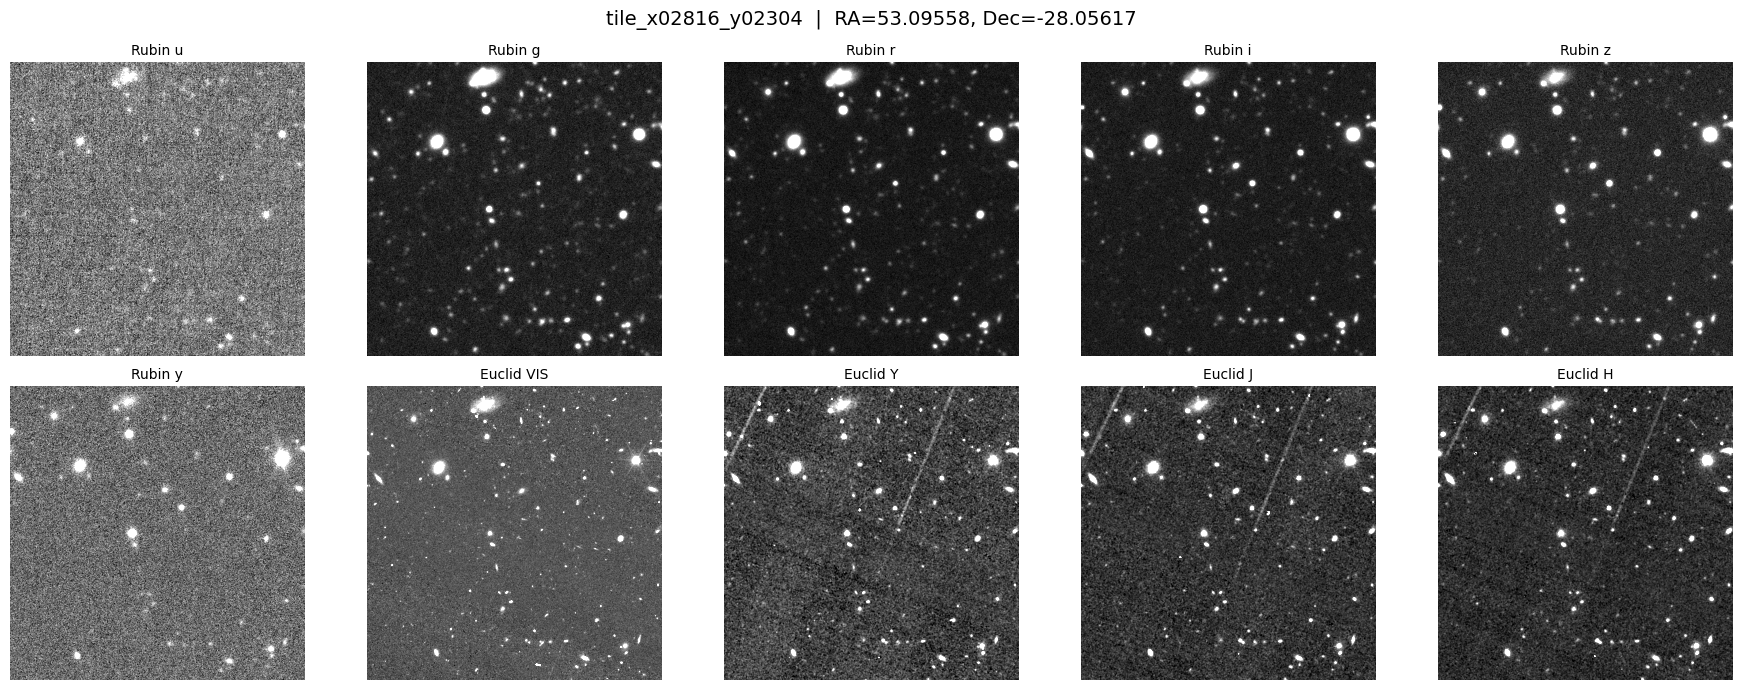

In [16]:
batch = next(iter(dl))   # already random if shuffle=True
i = random.randrange(len(batch["x_rubin"]))  # pick one sample in batch

def show(ax, img, title=None, qlo=1, qhi=99):
    vmin, vmax = np.percentile(img, (qlo, qhi))
    ax.imshow(img, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=10)

rubin = batch["x_rubin"][i].numpy()    # (6, Hr, Wr)
euclid = batch["x_euclid"][i].numpy()  # (4, He, We)
meta   = batch["meta"][i]

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.ravel()

# --- Rubin (top row) ---
for b, band in enumerate(meta["rubin_bands"]):
    show(
        axes[b],
        rubin[b],
        title=f"Rubin {band}"
    )

# empty slot (top-right)
axes[5].axis("off")

# --- Euclid (bottom row) ---
for b, band in enumerate(meta["euclid_bands"]):
    show(
        axes[6 + b],
        euclid[b],
        title=f"Euclid {band}"
    )

# empty slot (bottom-right)
axes[9].axis("off")

fig.suptitle(
    f"{meta['tile_id']}  |  RA={meta['ra_center']:.5f}, Dec={meta['dec_center']:.5f}",
    fontsize=14
)

plt.tight_layout()
plt.show()


In [21]:
b = next(iter(dl))
print("batch keys:", b.keys())

i = 0

print("Rubin RMS object:", batch["rms_rubin"][i])
print("Euclid RMS shape:", batch["rms_euclid"][i].shape)


batch keys: dict_keys(['x_rubin', 'x_euclid', 'mask_euclid', 'meta', 'rms_rubin', 'rms_euclid'])


Text(0.5, 0.98, 'RMS  |  tile_x02816_y02304')

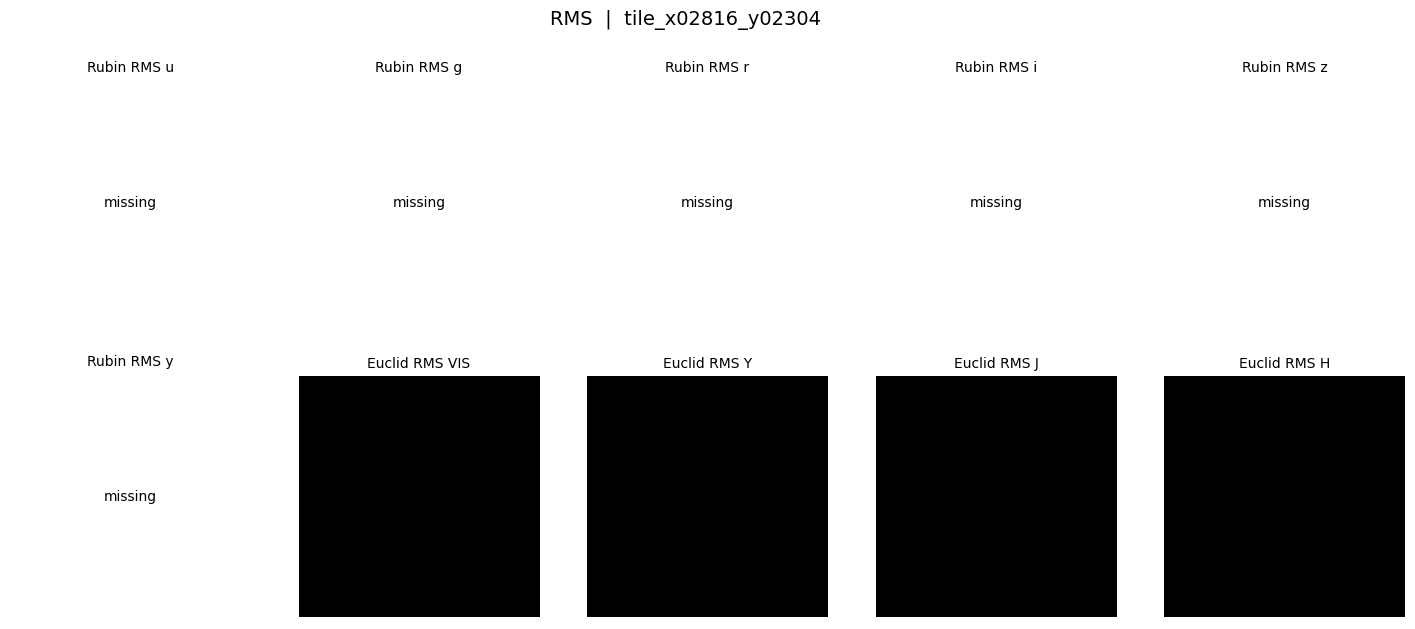

In [20]:
def show(ax, img, title=None, qlo=1, qhi=99):
    # handle missing
    if img is None:
        ax.text(0.5, 0.5, "missing", ha="center", va="center", fontsize=10)
        ax.axis("off")
        if title:
            ax.set_title(title, fontsize=10)
        return

    img = np.asarray(img)
    finite = np.isfinite(img)
    if finite.sum() == 0:
        ax.text(0.5, 0.5, "all-NaN", ha="center", va="center", fontsize=10)
        ax.axis("off")
        if title:
            ax.set_title(title, fontsize=10)
        return

    vmin, vmax = np.percentile(img[finite], (qlo, qhi))
    ax.imshow(img, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=10)

# RMS (may be missing for Rubin)
rubin_rms = None
if "rms_rubin" in batch and batch["rms_rubin"][i] is not None:
    rubin_rms = batch["rms_rubin"][i].numpy()

euclid_rms = batch["rms_euclid"][i].numpy()


# =======================
# RMS IMAGES
# =======================
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.ravel()

for b, band in enumerate(meta["rubin_bands"]):
    if rubin_rms is not None:
        show(axes[b], rubin_rms[b], title=f"Rubin RMS {band}")
    else:
        show(axes[b], None, title=f"Rubin RMS {band}")

axes[5].axis("off")

for b, band in enumerate(meta["euclid_bands"]):
    show(axes[6 + b], euclid_rms[b], title=f"Euclid RMS {band}")

axes[9].axis("off")

fig.suptitle(
    f"RMS  |  {meta['tile_id']}",
    fontsize=14
)


# Older (3 bands): 

In [ ]:
class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


In [ ]:
class TinyConv(nn.Module):
    def __init__(self, in_ch=3, out_ch=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_ch, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyConv().to(device)

img = img.to(device)
var = var.to(device)

out = model(img)
loss = (out**2).mean()   # dummy loss

loss.backward()
loss.item()

